In [1]:
from datetime import datetime
import os
import re

from itertools import combinations
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import sklearn as sk
import mlflow
from mlflow.entities import ViewType
from mlflow.tracking import MlflowClient
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from scipy.stats import pearsonr, chi2_contingency, ttest_ind

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

In [4]:
def load_data(data_path="data/train_base.parquet", cat_cols=None) -> pd.DataFrame:
    data = pd.read_parquet(data_path)
    base = data[["case_id", "WEEK_NUM", "target"]]
    data = data[[x for x in data.columns if x != "case_id"]]
    y = data["target"]
    if cat_cols is None:
        cat_cols = list(data.select_dtypes("object").columns)
    
    data[cat_cols] = data[cat_cols].astype("category")
    return base, data, y

In [3]:
base, data, y = load_data()

In [4]:
data.shape

(1526659, 515)

In [6]:
cat_cols_base = list(data.select_dtypes("category").columns)

In [7]:
numeric_cols_base = list(data.select_dtypes(include=np.number).columns)

In [8]:
numeric_cols_base

['WEEK_NUM',
 'target',
 'month_decision',
 'weekday_decision',
 'assignmentdate_238D',
 'assignmentdate_4527235D',
 'birthdate_574D',
 'contractssum_5085716L',
 'dateofbirth_337D',
 'days120_123L',
 'days180_256L',
 'days30_165L',
 'days360_512L',
 'days90_310L',
 'firstquarter_103L',
 'fourthquarter_440L',
 'numberofqueries_373L',
 'pmtaverage_3A',
 'pmtaverage_4527227A',
 'pmtcount_4527229L',
 'pmtcount_693L',
 'pmtscount_423L',
 'pmtssum_45A',
 'responsedate_1012D',
 'responsedate_4527233D',
 'responsedate_4917613D',
 'secondquarter_766L',
 'thirdquarter_1082L',
 'actualdpdtolerance_344P',
 'amtinstpaidbefduel24m_4187115A',
 'annuity_780A',
 'annuitynextmonth_57A',
 'applicationcnt_361L',
 'applications30d_658L',
 'applicationscnt_1086L',
 'applicationscnt_464L',
 'applicationscnt_629L',
 'applicationscnt_867L',
 'avgdbddpdlast24m_3658932P',
 'avgdbddpdlast3m_4187120P',
 'avgdbdtollast24m_4525197P',
 'avgdpdtolclosure24_3658938P',
 'avginstallast24m_3658937A',
 'avglnamtstart24m_45

In [9]:
cat_cols_base

['description_5085714M',
 'education_1103M',
 'education_88M',
 'maritalst_385M',
 'maritalst_893M',
 'requesttype_4525192L',
 'bankacctype_710L',
 'cardtype_51L',
 'credtype_322L',
 'disbursementtype_67L',
 'equalitydataagreement_891L',
 'inittransactioncode_186L',
 'isdebitcard_729L',
 'lastapprcommoditycat_1041M',
 'lastcancelreason_561M',
 'lastrejectcommoditycat_161M',
 'lastrejectcommodtypec_5251769M',
 'lastrejectreason_759M',
 'lastrejectreasonclient_4145040M',
 'lastst_736L',
 'opencred_647L',
 'paytype1st_925L',
 'paytype_783L',
 'twobodfilling_608L',
 'typesuite_864L',
 'max_cancelreason_3545846M',
 'max_education_1138M',
 'max_postype_4733339M',
 'max_rejectreason_755M',
 'max_rejectreasonclient_4145042M',
 'min_cancelreason_3545846M',
 'min_education_1138M',
 'min_postype_4733339M',
 'min_rejectreason_755M',
 'min_rejectreasonclient_4145042M',
 'first_cancelreason_3545846M',
 'first_education_1138M',
 'first_postype_4733339M',
 'first_rejectreason_755M',
 'first_rejectreas

In [10]:
len(numeric_cols_base), len(cat_cols_base)

(376, 138)

In [11]:
[x for x in data.columns if x not in cat_cols_base and x not in numeric_cols_base]

['isbidproduct_1095L']

In [12]:
data['isbidproduct_1095L'].describe()

count     1526659
unique          2
top         False
freq      1350049
Name: isbidproduct_1095L, dtype: object

In [13]:
data[data['isbidproduct_1095L'].isnull()]

,WEEK_NUM,target,month_decision,weekday_decision,assignmentdate_238D,assignmentdate_4527235D,birthdate_574D,contractssum_5085716L,dateofbirth_337D,days120_123L,days180_256L,days30_165L,days360_512L,days90_310L,description_5085714M,education_1103M,education_88M,firstquarter_103L,fourthquarter_440L,maritalst_385M,maritalst_893M,numberofqueries_373L,pmtaverage_3A,pmtaverage_4527227A,pmtcount_4527229L,pmtcount_693L,pmtscount_423L,pmtssum_45A,requesttype_4525192L,responsedate_1012D,responsedate_4527233D,responsedate_4917613D,secondquarter_766L,thirdquarter_1082L,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,applicationcnt_361L,applications30d_658L,applicationscnt_1086L,applicationscnt_464L,applicationscnt_629L,applicationscnt_867L,avgdbddpdlast24m_3658932P,avgdbddpdlast3m_4187120P,avgdbdtollast24m_4525197P,avgdpdtolclosure24_3658938P,avginstallast24m_3658937A,avglnamtstart24m_4525187A,avgmaxdpdlast9m_3716943P,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,bankacctype_710L,cardtype_51L,clientscnt12m_3712952L,clientscnt3m_3712950L,clientscnt6m_3712949L,clientscnt_100L,clientscnt_1022L,clientscnt_1071L,clientscnt_1130L,clientscnt_157L,clientscnt_257L,clientscnt_304L,clientscnt_360L,clientscnt_493L,clientscnt_533L,clientscnt_887L,clientscnt_946L,cntincpaycont9m_3716944L,cntpmts24_3658933L,commnoinclast6m_3546845L,credamount_770A,credtype_322L,currdebt_22A,currdebtcredtyperange_828A,datefirstoffer_1144D,datelastinstal40dpd_247D,datelastunpaid_3546854D,daysoverduetolerancedd_3976961L,deferredmnthsnum_166L,disbursedcredamount_1113A,disbursementtype_67L,downpmt_116A,dtlastpmtallstes_4499206D,eir_270L,equalitydataagreement_891L,firstclxcampaign_1125D,firstdatedue_489D,homephncnt_628L,inittransactionamount_650A,inittransactioncode_186L,interestrate_311L,isbidproduct_1095L,isdebitcard_729L,lastactivateddate_801D,lastapplicationdate_877D,lastapprcommoditycat_1041M,lastapprcredamount_781A,lastapprdate_640D,lastcancelreason_561M,lastdelinqdate_224D,lastrejectcommoditycat_161M,lastrejectcommodtypec_5251769M,lastrejectcredamount_222A,lastrejectdate_50D,lastrejectreason_759M,lastrejectreasonclient_4145040M,lastst_736L,maininc_215A,mastercontrelectronic_519L,mastercontrexist_109L,maxannuity_159A,maxdbddpdlast1m_3658939P,maxdbddpdtollast12m_3658940P,maxdbddpdtollast6m_4187119P,maxdebt4_972A,maxdpdfrom6mto36m_3546853P,maxdpdinstldate_3546855D,maxdpdinstlnum_3546846P,maxdpdlast12m_727P,maxdpdlast24m_143P,maxdpdlast3m_392P,maxdpdlast6m_474P,maxdpdlast9m_1059P,maxdpdtolerance_374P,maxinstallast24m_3658928A,maxlnamtstart6m_4525199A,maxoutstandbalancel12m_4187113A,maxpmtlast3m_4525190A,mindbddpdlast24m_3658935P,mindbdtollast24m_4525191P,mobilephncnt_593L,monthsannuity_845L,numactivecreds_622L,numactivecredschannel_414L,numactiverelcontr_750L,numcontrs3months_479L,numincomingpmts_3546848L,numinstlallpaidearly3d_817L,numinstls_657L,numinstlsallpaid_934L,numinstlswithdpd10_728L,numinstlswithdpd5_4187116L,numinstlswithoutdpd_562L,numinstmatpaidtearly2d_4499204L,numinstpaid_4499208L,numinstpaidearly3d_3546850L,numinstpaidearly3dest_4493216L,numinstpaidearly5d_1087L,numinstpaidearly5dest_4493211L,numinstpaidearly5dobd_4499205L,numinstpaidearly_338L,numinstpaidearlyest_4493214L,numinstpaidlastcontr_4325080L,numinstpaidlate1d_3546852L,numinstregularpaid_973L,numinstregularpaidest_4493210L,numinsttopaygr_769L,numinsttopaygrest_4493213L,numinstunpaidmax_3546851L,numinstunpaidmaxest_4493212L,numnotactivated_1143L,numpmtchanneldd_318L,numrejects9m_859L,opencred_647L,paytype1st_925L,paytype_783L,pctinstlsallpaidearl3d_427L,pctinstlsallpaidlat10d_839L,pctinstlsallpaidlate1d_3546856L,pctinstlsallpaidlate4d_3546849L,pctinstlsallpaidlate6d_3546844L,pmtnum_254L,posfpd10lastmonth_333P,posfpd30lastmonth_3976960P,posfstqpd30lastmonth_3976962P,price_1097A,sellerplacecnt_915L,sellerplacescnt_216L,sumoutstandtotal_3546847A,sumoutstandtotalest_4493215A,totaldebt_9A,totalsettled_863A,totinstallast1m_4525188A,twobodfilling_608L,types

In [14]:
data[data['isbidproduct_1095L']]['target'].describe()

count    176610.000000
mean          0.033701
std           0.180460
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: target, dtype: float64

In [15]:
data[~data['isbidproduct_1095L']]['target'].describe()

count    1.350049e+06
mean     3.114109e-02
std      1.736990e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: target, dtype: float64

In [16]:
ttest_ind(data[data['isbidproduct_1095L']]['target'], data[~data['isbidproduct_1095L']]['target'])

TtestResult(statistic=5.798527237975089, pvalue=6.691295216202485e-09, df=1526657.0)

In [17]:
data['isbidproduct_1095L'] = data['isbidproduct_1095L'].astype("category")

In [18]:
data['isbidproduct_1095L'].describe()

count     1526659
unique          2
top         False
freq      1350049
Name: isbidproduct_1095L, dtype: object

In [19]:
# Are there any categorical variables with one value only?
def remove_single_val_cols(data, cat_cols_base):
    cols_to_drop = []
    for col in cat_cols_base:
        if data[col].nunique() == 1:
            print(col)
            cols_to_drop.append(col)
    return data.drop(columns=cols_to_drop)

In [20]:
# the safest way for now is to remove these
data = remove_single_val_cols(data, cat_cols_base)
# update cat cols
cat_cols_base = list(data.select_dtypes("category").columns)

bankacctype_710L
isdebitcard_729L
paytype1st_925L
paytype_783L
typesuite_864L
min_isbidproduct_390L
max_contaddr_matchlist_1032L
max_remitter_829L
min_contaddr_matchlist_1032L
min_remitter_829L
first_contaddr_matchlist_1032L
last_contaddr_matchlist_1032L
last_remitter_829L


In [21]:
data.loc[data['last_empladdr_district_926M'] == 'P76_152_180', 'last_empladdr_district_926M']

327175    P76_152_180
345294    P76_152_180
Name: last_empladdr_district_926M, dtype: category
Categories (22, object): ['P112_89_137', 'P114_147_118', 'P117_30_169', 'P120_80_181', ..., 'P54_133_26', 'P76_152_180', 'P80_85_140', 'a55475b1']

In [63]:
# let's check if we have a lot of categorical variables with rare values (like less than 10)
for col in cat_cols_base:
    for val in data[col].unique():
        count = len(data[data[col] == val])
        if count < 10:
            print(col, val, count)

description_5085714M nan 0
education_1103M nan 0
education_88M nan 0
maritalst_385M nan 0
maritalst_893M nan 0
requesttype_4525192L nan 0
cardtype_51L nan 0
credtype_322L nan 0
disbursementtype_67L nan 0
equalitydataagreement_891L nan 0
inittransactioncode_186L nan 0
lastapprcommoditycat_1041M P201_108_190 3
lastapprcommoditycat_1041M P117_143_46 6
lastapprcommoditycat_1041M P126_161_96 4
lastapprcommoditycat_1041M P155_91_176 1
lastapprcommoditycat_1041M P93_39_173 1
lastapprcommoditycat_1041M P58_25_91 2
lastapprcommoditycat_1041M P187_21_169 2
lastcancelreason_561M P91_110_150 2
lastcancelreason_561M P151_143_25 2
lastcancelreason_561M P65_58_157 1
lastcancelreason_561M P129_101_181 4
lastcancelreason_561M P7_85_64 2
lastcancelreason_561M P60_137_164 1
lastcancelreason_561M P188_66_164 3
lastcancelreason_561M P68_132_180 5
lastcancelreason_561M P89_110_159 1
lastcancelreason_561M P17_160_152 4
lastcancelreason_561M P199_114_13 6
lastcancelreason_561M P72_115_176 3
lastcancelreason_5

In [22]:
def rare_values_to_others(data: pd.DataFrame):
    for col in cat_cols_base:
        for val in data[col].unique():
            count = len(data[data[col] == val])
            if count < 10 and count > 0:
                if 'other' not in data[col].cat.categories:
                    print(col, val)
                    data[col] = data[col].cat.add_categories('other')
                data.loc[data[col] == val, col] = 'other'

In [23]:
rare_values_to_others(data)

lastapprcommoditycat_1041M P201_108_190
lastcancelreason_561M P91_110_150
lastrejectcommoditycat_161M P38_69_128
lastrejectcommodtypec_5251769M P185_44_170
lastrejectreason_759M P185_59_178
lastrejectreasonclient_4145040M P59_114_135
max_cancelreason_3545846M P32_86_86
max_rejectreason_755M P53_10_15
max_rejectreasonclient_4145042M P30_86_84
min_cancelreason_3545846M P91_110_150
min_rejectreasonclient_4145042M P59_114_135
first_cancelreason_3545846M P91_110_150
first_rejectreason_755M P185_59_178
first_rejectreasonclient_4145042M P59_114_135
last_cancelreason_3545846M P91_110_150
last_rejectreason_755M P19_25_34
last_rejectreasonclient_4145042M P64_121_167
mode_cancelreason_3545846M P91_110_150
mode_rejectreason_755M P69_72_116
mode_rejectreasonclient_4145042M P59_114_135
last_status_219L P
max_empladdr_district_926M P204_99_158
max_empladdr_zipcode_114M P212_16_169
last_empladdr_district_926M P204_99_158
last_empladdr_zipcode_114M P212_16_169
max_incometype_1044T HANDICAPPED
min_incom

# NEXT STEPS
0. A lot of data analysis and cleaning already went into the dataset credit to other kagglers, which resulted in clean datatypes, datetime transformations into numerical features and various aggregations applied to multi-level data.
1. For now we will skip outlier detection since gbm tree models can hadnle them gracefully. We may come back to it later.
2. Same goes to standarization
3. A lot of attention has to go to the analysis of missing values. Even though lgb seems to handle them really well on this dataset, we'll try various things nevertheless. I've already done some analysis on paper, so I'll write down the findings below and try to sum them up
4. I'll look at some correlations between predictors as well as target-predictor
5. Then try to come up with some nice visualization with t-SNE
6. We'll see if some multivar analysis provides anything useful
7. We'll try to cluster the cases into some meaningful groups - my first bet is we should be able to divide customers into three groups: those with no previous credit history, those who have default/dpd history, those with clean score. Might make sense to train separate models on them or just encode it as a categorical variable

# Single variable analysis

In [31]:
# Bivariate Analysis

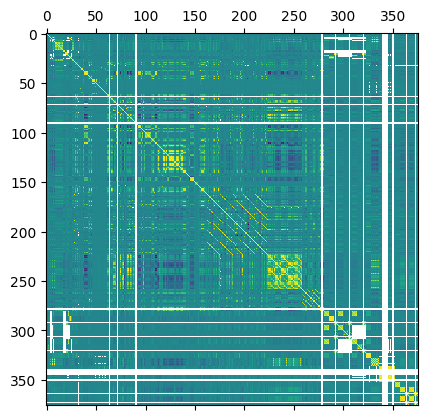

In [22]:
plt.matshow(data[numeric_cols_base].corr())

In [47]:
# that's not very helpful, let's try to do a pairwise comparison of variables
# starting with categorical variables using chi2
def cat_cols_correlation_check(data, comb_categorical):
    corrs = []
    for comb in comb_categorical:
        table = pd.pivot_table(data, values='target', index=comb[0], columns=comb[1], aggfunc='count').fillna(0)
        # only proceed if the minimum cell count is at least 5, following chi2 recommendations
        if np.min(table) > 4:
            corr = np.sqrt(chi2_contingency(table)[0] / (table.values.sum() * (np.min(table.shape) - 1) ) )
            corrs.append((comb, corr))
        return corrs

In [ ]:
comb_categorical = list(combinations(cat_cols_base, 2))
corrs = cat_cols_correlation_check(data, comb_categorical)

In [45]:
# let's see what higly correlated features we have
high_corrs = [x for x in corrs if x[1] > 0.6]
high_corrs

[(('disbursementtype_67L', 'isbidproduct_1095L'), 0.619582441161269),
 (('inittransactioncode_186L', 'isbidproduct_1095L'), 0.6198437466108865),
 (('first_familystate_726L', 'last_familystate_726L'), 0.6514378092622854),
 (('max_language1_981M', 'min_education_927M'), 0.6445612683637434),
 (('max_language1_981M', 'first_education_927M'), 0.6394271101424214),
 (('min_education_927M', 'last_language1_981M'), 0.6445612683637434),
 (('first_education_927M', 'last_language1_981M'), 0.6394271101424214),
 (('mode_language1_981M', 'max_role_1084L'), 0.6194814149522839),
 (('mode_language1_981M', 'last_role_1084L'), 0.6063486490038129)]

# There are some highly correlated pairs but not enough to warrant removing them right away

In [69]:
def numeric_cols_correlation_check(data, combs):
    corrs = []
    for comb in combs:
        corr = pearsonr(data[comb[0]].fillna(0), data[comb[1]].fillna(0))[0]
        if corr > 0.8:
            corrs.append((comb, corr))
    return corrs

In [70]:
comb_numerical = list(combinations(numeric_cols_base, 2))
high_corrs = numeric_cols_correlation_check(data, comb_numerical)
high_corrs

/tmp/ipykernel_25317/1405184732.py:4: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr = pearsonr(data[comb[0]].fillna(0), data[comb[1]].fillna(0))[0]


[(('assignmentdate_4527235D', 'pmtaverage_4527227A'), 0.8701981745588807),
 (('assignmentdate_4527235D', 'pmtcount_4527229L'), 0.9446699536764067),
 (('days120_123L', 'days180_256L'), 0.9108004023992458),
 (('days120_123L', 'days90_310L'), 0.9227476407737293),
 (('days180_256L', 'days360_512L'), 0.8718230874270961),
 (('days180_256L', 'days90_310L'), 0.833828257288093),
 (('days180_256L', 'numberofqueries_373L'), 0.8718230874270961),
 (('days360_512L', 'numberofqueries_373L'), 1.0),
 (('pmtaverage_3A', 'pmtcount_693L'), 0.8408622324049234),
 (('pmtscount_423L', 'max_num_group1_1_5'), 0.9973950703834822),
 (('pmtscount_423L', 'first_num_group1_1_5'), 0.8031272756415347),
 (('pmtscount_423L', 'last_num_group1_1_5'), 0.8037560970411798),
 (('pmtssum_45A', 'max_pmtamount_36A'), 0.9364075580764496),
 (('pmtssum_45A', 'first_pmtamount_36A'), 0.8492089153472376),
 (('pmtssum_45A', 'last_pmtamount_36A'), 0.8490522697197596),
 (('pmtssum_45A', 'mean_pmtamount_36A'), 0.938511775061093),
 (('actu

In [74]:
def get_corr_cols_to_rm(data, corrs):
    to_rm = []
    for (col1, col2), _ in corrs:
        if len(data[data[col1].isnull()]) > len(data[data[col2].isnull()]):
            to_rm.append(col1)
        else:
            to_rm.append(col2)
    return list(set(to_rm))

In [75]:
cols_to_rm = get_corr_cols_to_rm(data, high_corrs)
cols_to_rm

['first_empl_employedfrom_271D',
 'last_childnum_21L',
 'first_pmtamount_36A',
 'maxdpdlast24m_143P',
 'mean_dtlastpmt_581D',
 'avgdpdtolclosure24_3658938P',
 'numinstpaidearly5dobd_4499205L',
 'first_num_group1_1_5',
 'numberofqueries_373L',
 'max_num_group1_1_3',
 'mean_dtlastpmtallstes_3545839D',
 'firstdatedue_489D',
 'pmtaverage_4527227A',
 'min_employedfrom_700D',
 'first_amount_4917619A',
 'credamount_770A',
 'pctinstlsallpaidlat10d_839L',
 'mean_openingdate_857D',
 'last_persontype_1072L',
 'last_actualdpd_943P',
 'numinstpaidearly_338L',
 'max_maxdpdtolerance_577P',
 'first_tenor_203L',
 'first_creationdate_885D',
 'numinstlsallpaid_934L',
 'max_num_group1_1_7',
 'min_tenor_203L',
 'mean_credacc_actualbalance_314A',
 'days180_256L',
 'first_dateactivated_425D',
 'last_tenor_203L',
 'mean_actualdpd_943P',
 'mean_empl_employedfrom_271D',
 'mean_mainoccupationinc_437A',
 'last_dtlastpmt_581D',
 'numinstlswithoutdpd_562L',
 'min_recorddate_4527225D',
 'currdebt_22A',
 'mean_openin

In [24]:
cols_to_rm = ['first_empl_employedfrom_271D',
 'last_childnum_21L',
 'first_pmtamount_36A',
 'maxdpdlast24m_143P',
 'mean_dtlastpmt_581D',
 'avgdpdtolclosure24_3658938P',
 'numinstpaidearly5dobd_4499205L',
 'first_num_group1_1_5',
 'numberofqueries_373L',
 'max_num_group1_1_3',
 'mean_dtlastpmtallstes_3545839D',
 'firstdatedue_489D',
 'pmtaverage_4527227A',
 'min_employedfrom_700D',
 'first_amount_4917619A',
 'credamount_770A',
 'pctinstlsallpaidlat10d_839L',
 'mean_openingdate_857D',
 'last_persontype_1072L',
 'last_actualdpd_943P',
 'numinstpaidearly_338L',
 'max_maxdpdtolerance_577P',
 'first_tenor_203L',
 'first_creationdate_885D',
 'numinstlsallpaid_934L',
 'max_num_group1_1_7',
 'min_tenor_203L',
 'mean_credacc_actualbalance_314A',
 'days180_256L',
 'first_dateactivated_425D',
 'last_tenor_203L',
 'mean_actualdpd_943P',
 'mean_empl_employedfrom_271D',
 'mean_mainoccupationinc_437A',
 'last_dtlastpmt_581D',
 'numinstlswithoutdpd_562L',
 'min_recorddate_4527225D',
 'currdebt_22A',
 'mean_openingdate_313D',
 'disbursedcredamount_1113A',
 'min_approvaldate_319D',
 'mean_employedfrom_700D',
 'min_openingdate_857D',
 'maxdbddpdtollast6m_4187119P',
 'first_amount_4527230A',
 'last_deductiondate_4917603D',
 'first_num_group1_1_4',
 'maxdpdlast6m_474P',
 'first_deductiondate_4917603D',
 'max_persontype_1072L',
 'avgdbddpdlast24m_3658932P',
 'first_firstnonzeroinstldate_307D',
 'mean_mainoccupationinc_384A',
 'numinstregularpaid_973L',
 'actualdpdtolerance_344P',
 'min_firstnonzeroinstldate_307D',
 'avgoutstandbalancel6m_4187114A',
 'min_credacc_actualbalance_314A',
 'max_persontype_792L',
 'avgdbddpdlast3m_4187120P',
 'max_creationdate_885D',
 'last_amount_4527230A',
 'first_amount_416A',
 'sumoutstandtotalest_4493215A',
 'maxdpdfrom6mto36m_3546853P',
 'maxdpdlast9m_1059P',
 'mean_recorddate_4527225D',
 'days90_310L',
 'last_maxdpdtolerance_577P',
 'lastactivateddate_801D',
 'interestrate_311L',
 'mean_maxdpdtolerance_577P',
 'last_num_group1_1_5',
 'last_creationdate_885D',
 'last_num_group1_1_3',
 'mean_birth_259D',
 'last_num_group1_1_8',
 'mean_annuity_853A',
 'min_credacc_maxhisbal_375A',
 'last_openingdate_857D',
 'first_openingdate_857D',
 'mean_amount_4527230A',
 'min_credacc_minhisbal_90A',
 'first_birth_259D',
 'applicationscnt_629L',
 'numinstregularpaidest_4493210L',
 'datelastunpaid_3546854D',
 'max_firstnonzeroinstldate_307D',
 'max_dateactivated_425D',
 'mean_dateactivated_425D',
 'first_dtlastpmt_581D',
 'last_num_group1',
 'clientscnt3m_3712950L',
 'last_processingdate_168D',
 'min_mainoccupationinc_384A',
 'max_currdebt_94A',
 'mean_credamount_590A',
 'min_openingdate_313D',
 'min_empl_employedfrom_271D',
 'max_num_group1_1_8',
 'mean_amount_4917619A',
 'maxdpdtolerance_374P',
 'last_pmtamount_36A',
 'first_actualdpd_943P',
 'mean_processingdate_168D',
 'min_outstandingdebt_522A',
 'numincomingpmts_3546848L',
 'numinstpaid_4499208L',
 'first_mainoccupationinc_437A',
 'mean_firstnonzeroinstldate_307D',
 'max_approvaldate_319D',
 'mean_credacc_minhisbal_90A',
 'min_dateactivated_425D',
 'datefirstoffer_1144D',
 'first_num_group1_1_3',
 'numinstpaidearlyest_4493214L',
 'pmtaverage_3A',
 'mean_credacc_maxhisbal_375A',
 'max_openingdate_857D',
 'mean_approvaldate_319D',
 'first_mainoccupationinc_384A',
 'numinstpaidearly3d_3546850L',
 'max_num_group1_1_5',
 'numinsttopaygr_769L',
 'maxoutstandbalancel12m_4187113A',
 'numinstunpaidmaxest_4493212L',
 'last_approvaldate_319D',
 'max_pmtamount_36A',
 'days360_512L',
 'pctinstlsallpaidlate4d_3546849L',
 'sumoutstandtotal_3546847A',
 'clientscnt_1022L',
 'mindbddpdlast24m_3658935P',
 'last_num_group1_1_7',
 'first_processingdate_168D',
 'last_outstandingdebt_522A',
 'last_employedfrom_700D',
 'pctinstlsallpaidlate6d_3546844L',
 'first_openingdate_313D',
 'first_outstandingdebt_522A',
 'last_amount_416A',
 'pmtcount_4527229L',
 'maxdbddpdlast1m_3658939P',
 'mean_deductiondate_4917603D',
 'last_num_group1_1_9',
 'last_mainoccupationinc_437A',
 'mean_creationdate_885D',
 'monthsannuity_845L',
 'last_amount_4917619A',
 'last_firstnonzeroinstldate_307D',
 'maxdbddpdtollast12m_3658940P',
 'last_dateactivated_425D',
 'max_outstandingdebt_522A',
 'last_recorddate_4527225D',
 'mindbdtollast24m_4525191P',
 'clientscnt6m_3712949L',
 'numinstmatpaidtearly2d_4499204L',
 'first_num_group1_1_8',
 'last_num_group1_1_4',
 'first_recorddate_4527225D',
 'mean_outstandingdebt_522A',
 'max_tenor_203L',
 'numinstunpaidmax_3546851L',
 'mean_pmtamount_36A',
 'min_birth_259D',
 'sellerplacescnt_216L',
 'mean_revolvingaccount_394A',
 'last_persontype_792L',
 'mean_amount_416A',
 'last_openingdate_313D',
 'min_dtlastpmt_581D',
 'min_revolvingaccount_394A']


In [25]:
len(cols_to_rm)

172

In [26]:
data.shape

(1526659, 502)

In [27]:
data = data.drop(columns=cols_to_rm)
data.shape

(1526659, 330)

In [28]:
data.shape # after removing single val cols

(1526659, 330)

In [29]:
data['last_contaddr_smempladdr_334L'].value_counts()

last_contaddr_smempladdr_334L
False    769333
other         5
True          0
Name: count, dtype: int64

In [30]:
data = data.drop(columns=['last_contaddr_smempladdr_334L'])

In [52]:
data.to_parquet('data/training_data_cleaned.parquet')

In [32]:
base.to_parquet('data/base_data.parquet')

# Fill missing values
There is a lot of columns with a significant percentage of missing values. One has to be careful filling with some default value.  
For instance, variables with 'reject' in name give lower default rate when null, while the variables related to tax deduction have higher default rate when null.  
For instance if dwonpayment is null, probably means there is no record of previous applications of the client.

You can try fill with -1 for cols with dpd, downpayment, installment in name  
You can try fill with 0 for cols with balance, deductions

In [49]:
data[[x for x in data.columns if 'dpd' in x and x in numeric_cols_base]].min()

avgmaxdpdlast9m_3716943P         0.0
datelastinstal40dpd_247D     -5227.0
maxdpdinstldate_3546855D     -5271.0
maxdpdinstlnum_3546846P          0.0
maxdpdlast12m_727P               0.0
maxdpdlast3m_392P                0.0
numinstlswithdpd10_728L          0.0
numinstlswithdpd5_4187116L       0.0
max_actualdpd_943P               0.0
min_actualdpd_943P               0.0
min_maxdpdtolerance_577P         0.0
first_maxdpdtolerance_577P       0.0
dtype: float64

In [50]:
data[[x for x in data.columns if 'instal' in x and x in numeric_cols_base]].min()

avginstallast24m_3658937A       0.000
datelastinstal40dpd_247D    -5227.000
maxinstallast24m_3658928A       0.000
totinstallast1m_4525188A        0.214
dtype: float64

In [44]:
data[data['maxdpdlast3m_392P'].isnull()].shape

(306019, 329)

In [74]:
def fill_min(data: pd.DataFrame, numeric_cols_base):
    data[[x for x in data.columns if 'dpd' in x and x in numeric_cols_base]] = data[[x for x in data.columns if 'dpd' in x and x in numeric_cols_base]].fillna(0)
    data[['datelastinstal40dpd_247D']] = data[['datelastinstal40dpd_247D']].fillna(data['datelastinstal40dpd_247D'].min())
    data[['maxdpdinstldate_3546855D']] = data[['maxdpdinstldate_3546855D']].fillna(data['maxdpdinstldate_3546855D'].min())

In [75]:
fill_min(data,numeric_cols_base)

In [54]:
[[x for x in data.columns if 'deduc' in x and x in numeric_cols_base]]

[['max_deductiondate_4917603D', 'min_deductiondate_4917603D']]

In [59]:
def fill0(data: pd.DataFrame, numeric_cols_base):
    cols_to_fill = [x for x in data.columns if ('deduc' in x or 'balanc' in x) and x in numeric_cols_base]
    data[cols_to_fill] = data[cols_to_fill].fillna(0)

In [60]:
fill0(data, numeric_cols_base)

In [61]:
data['datelastinstal40dpd_247D']

0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
          ... 
1526654    0.0
1526655    0.0
1526656    0.0
1526657    0.0
1526658    0.0
Name: datelastinstal40dpd_247D, Length: 1526659, dtype: float64

In [65]:
data[data['datelastinstal40dpd_247D'] == data['datelastinstal40dpd_247D'].min()]['datelastinstal40dpd_247D']

1346918   -5227.0
Name: datelastinstal40dpd_247D, dtype: float64

In [67]:
data['maxdpdinstldate_3546855D'].describe()

count    1.526659e+06
mean    -4.619751e+02
std      9.609243e+02
min     -5.271000e+03
25%     -4.150000e+02
50%      0.000000e+00
75%      0.000000e+00
max      1.300000e+01
Name: maxdpdinstldate_3546855D, dtype: float64

In [71]:
data[data['maxdpdinstldate_3546855D'] < -5200]['maxdpdinstldate_3546855D']

211368    -5248.0
1288777   -5206.0
1298269   -5217.0
1298852   -5270.0
1300451   -5219.0
1303807   -5209.0
1306616   -5215.0
1316223   -5219.0
1320777   -5235.0
1332760   -5227.0
1337802   -5206.0
1342152   -5210.0
1349207   -5271.0
1350996   -5205.0
1351205   -5232.0
1522588   -5219.0
1522638   -5202.0
1525808   -5222.0
Name: maxdpdinstldate_3546855D, dtype: float64

In [92]:
data[data['max_amount_4527230A'].isnull()]

,WEEK_NUM,target,month_decision,weekday_decision,assignmentdate_238D,assignmentdate_4527235D,birthdate_574D,contractssum_5085716L,dateofbirth_337D,days120_123L,days30_165L,description_5085714M,education_1103M,education_88M,firstquarter_103L,fourthquarter_440L,maritalst_385M,maritalst_893M,pmtcount_693L,pmtscount_423L,pmtssum_45A,requesttype_4525192L,responsedate_1012D,responsedate_4527233D,responsedate_4917613D,secondquarter_766L,thirdquarter_1082L,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,applicationcnt_361L,applications30d_658L,applicationscnt_1086L,applicationscnt_464L,applicationscnt_867L,avgdbdtollast24m_4525197P,avginstallast24m_3658937A,avglnamtstart24m_4525187A,avgmaxdpdlast9m_3716943P,avgpmtlast12m_4525200A,cardtype_51L,clientscnt12m_3712952L,clientscnt_100L,clientscnt_1071L,clientscnt_1130L,clientscnt_157L,clientscnt_257L,clientscnt_304L,clientscnt_360L,clientscnt_493L,clientscnt_533L,clientscnt_887L,clientscnt_946L,cntincpaycont9m_3716944L,cntpmts24_3658933L,commnoinclast6m_3546845L,credtype_322L,currdebtcredtyperange_828A,datelastinstal40dpd_247D,daysoverduetolerancedd_3976961L,deferredmnthsnum_166L,disbursementtype_67L,downpmt_116A,dtlastpmtallstes_4499206D,eir_270L,equalitydataagreement_891L,firstclxcampaign_1125D,homephncnt_628L,inittransactionamount_650A,inittransactioncode_186L,isbidproduct_1095L,lastapplicationdate_877D,lastapprcommoditycat_1041M,lastapprcredamount_781A,lastapprdate_640D,lastcancelreason_561M,lastdelinqdate_224D,lastrejectcommoditycat_161M,lastrejectcommodtypec_5251769M,lastrejectcredamount_222A,lastrejectdate_50D,lastrejectreason_759M,lastrejectreasonclient_4145040M,lastst_736L,maininc_215A,mastercontrelectronic_519L,mastercontrexist_109L,maxannuity_159A,maxdebt4_972A,maxdpdinstldate_3546855D,maxdpdinstlnum_3546846P,maxdpdlast12m_727P,maxdpdlast3m_392P,maxinstallast24m_3658928A,maxlnamtstart6m_4525199A,maxpmtlast3m_4525190A,mobilephncnt_593L,numactivecreds_622L,numactivecredschannel_414L,numactiverelcontr_750L,numcontrs3months_479L,numinstlallpaidearly3d_817L,numinstls_657L,numinstlswithdpd10_728L,numinstlswithdpd5_4187116L,numinstpaidearly3dest_4493216L,numinstpaidearly5d_1087L,numinstpaidearly5dest_4493211L,numinstpaidlastcontr_4325080L,numinstpaidlate1d_3546852L,numinsttopaygrest_4493213L,numnotactivated_1143L,numpmtchanneldd_318L,numrejects9m_859L,opencred_647L,pctinstlsallpaidearl3d_427L,pctinstlsallpaidlate1d_3546856L,pmtnum_254L,posfpd10lastmonth_333P,posfpd30lastmonth_3976960P,posfstqpd30lastmonth_3976962P,price_1097A,sellerplacecnt_915L,totaldebt_9A,totalsettled_863A,totinstallast1m_4525188A,twobodfilling_608L,validfrom_1069D,max_actualdpd_943P,max_annuity_853A,max_credacc_actualbalance_314A,max_credacc_credlmt_575A,max_credacc_maxhisbal_375A,max_credacc_minhisbal_90A,max_credamount_590A,max_downpmt_134A,max_mainoccupationinc_437A,max_revolvingaccount_394A,min_actualdpd_943P,min_annuity_853A,min_credacc_credlmt_575A,min_credamount_590A,min_currdebt_94A,min_downpmt_134A,min_mainoccupationinc_437A,min_maxdpdtolerance_577P,first_annuity_853A,first_credacc_credlmt_575A,first_credamount_590A,first_currdebt_94A,first_downpmt_134A,first_maxdpdtolerance_577P,first_revolvingaccount_394A,last_annuity_853A,last_credacc_actualbalance_314A,last_credacc_credlmt_575A,last_credacc_maxhisbal_375A,last_credacc_minhisbal_90A,last_credamount_590A,last_currdebt_94A,last_downpmt_134A,mean_credacc_credlmt_575A,mean_currdebt_94A,mean_downpmt_134A,max_dtlastpmt_581D,max_dtlastpmtallstes_3545839D,max_employedfrom_700D,min_creationdate_885D,min_dtlastpmtallstes_3545839D,first_approvaldate_319D,first_dtlastpmtallstes_3545839D,first_employedfrom_700D,last_dtlastpmtallstes_3545839D,max_cancelreason_3545846M,max_education_1138M,max_postype_4733339M,max_rejectreason_755M,max_rejectreasonclient_4145042M,min_cancelreason_3545846M,min_education_1138M,min_postype_4733339M,min_rejectreason_755M,min_rejectreasonclient_4145042M,first_cancelreason_3545846M,first_education_1138M,first_postype_4733339

In [78]:
data['pmtssum_45A'].describe()

count    572638.000000
mean      13199.935970
std       18117.218312
min           0.000000
25%        3156.400100
50%        8391.900000
75%       16992.000000
max      476843.400000
Name: pmtssum_45A, dtype: float64

In [81]:
data['lastdelinqdate_224D'].describe()

count    548684.000000
mean       -538.509900
std         646.678984
min       -4930.000000
25%        -800.000000
50%        -297.000000
75%         -72.000000
max          13.000000
Name: lastdelinqdate_224D, dtype: float64

In [82]:
data['max_pmtnum_8L'].describe()

count    1.205213e+06
mean     2.304816e+01
std      1.282552e+01
min      3.000000e+00
25%      1.200000e+01
50%      2.400000e+01
75%      3.000000e+01
max      6.300000e+01
Name: max_pmtnum_8L, dtype: float64

In [84]:
data['applicationscnt_867L'].describe()

count    1.526659e+06
mean     2.880360e+00
std      4.346472e+00
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      4.000000e+00
max      2.870000e+02
Name: applicationscnt_867L, dtype: float64

In [94]:
data['max_amount_4527230A'].describe()

count    457934.000000
mean       4156.414694
std        5127.638735
min           0.000000
25%        1258.800000
50%        2635.000000
75%        4962.200000
max       87115.600000
Name: max_amount_4527230A, dtype: float64

In [15]:
from sklearn.impute import KNNImputer

In [3]:
def indicate_missing_values(data: pd.DataFrame):
    return pd.concat([data, data.isnull().astype(int).add_suffix('_indicator')], axis=1)

In [ ]:
data = indicate_missing_values(data)
data.shape

In [ ]:
data.head()

In [23]:
df = pd.DataFrame({'col1': [1,2,np.NAN], 'col2': [np.NAN, 4,6], 'col3':['a','b','c']})
df

,col1,col2,col3
0,1.0,NaN,a
1,2.0,4.0,b
2,NaN,6.0,c


In [24]:
df = indicate_missing_values(df)
df

,col1,col2,col3,col1_indicator,col2_indicator,col3_indicator
0,1.0,NaN,a,0,1,0
1,2.0,4.0,b,0,0,0
2,NaN,6.0,c,1,0,0


In [25]:
df[['col3']] = df[['col3']].astype('category')

In [10]:
dummies = pd.get_dummies(df[['col3']], drop_first=True)
dummies

,col3_b,col3_c
0,False,False
1,True,False
2,False,True


In [13]:
df = pd.concat([df, dummies], axis=1)
df

,col1,col2,col3,col1_indicator,col2_indicator,col3_indicator,col3_b,col3_c
0,1.0,NaN,a,0,1,0,False,False
1,2.0,4.0,b,0,0,0,True,False
2,NaN,6.0,c,1,0,0,False,True


In [26]:
def dummify_categorical(data: pd.DataFrame, cols):
    dummies = pd.get_dummies(df[cols], drop_first=True).astype(int)
    return pd.concat([data.drop(columns=cols), dummies], axis=1)

In [27]:
df = dummify_categorical(df, ['col3'])

In [28]:
df

,col1,col2,col1_indicator,col2_indicator,col3_indicator,col3_b,col3_c
0,1.0,NaN,0,1,0,0,0
1,2.0,4.0,0,0,0,1,0
2,NaN,6.0,1,0,0,0,1


In [31]:
def fill_knn(data:pd.DataFrame):
    knn_imputer = KNNImputer(n_neighbors=5)
    imp_df = knn_imputer.fit_transform(df)
    return pd.DataFrame(imp_df, columns=df.columns)

In [30]:
df = pd.DataFrame(imp_df, columns=df.columns)
df

,col1,col2,col1_indicator,col2_indicator,col3_indicator,col3_b,col3_c
0,1.0,5.0,0.0,1.0,0.0,0.0,0.0
1,2.0,4.0,0.0,0.0,0.0,1.0,0.0
2,1.5,6.0,1.0,0.0,0.0,0.0,1.0


In [32]:
fill_knn(df)

,col1,col2,col1_indicator,col2_indicator,col3_indicator,col3_b,col3_c
0,1.0,5.0,0.0,1.0,0.0,0.0,0.0
1,2.0,4.0,0.0,0.0,0.0,1.0,0.0
2,1.5,6.0,1.0,0.0,0.0,0.0,1.0
